In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
dataset = pd.read_csv(r'C:\Users\UMANG\Downloads\Py_DS_ML_Bootcamp-master\Refactored_Py_DS_ML_Bootcamp-master\22-Deep Learning\TensorFlow_FILES\TensorFlow_FILES\Notebooks\Tweets.csv')

In [3]:
dataset.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
dataset['airline'].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

In [5]:
dataset = dataset.sample(frac=1).reset_index(drop=True)
dataset.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570175202807586816,negative,1.0000,Customer Service Issue,1.0,United,NaN,sothenbethsaid,NaN,0,@united hence why I've been asking for the cus...,NaN,2015-02-24 02:55:36 -0800,Nottingham,London
1,570263448828780547,positive,1.0000,NaN,NaN,American,NaN,ELLLORRAC,NaN,0,@AmericanAir great customer service thanks,NaN,2015-02-24 08:46:15 -0800,NaN,Central Time (US & Canada)
2,568884379600224258,neutral,0.6457,NaN,NaN,Delta,NaN,alixpeabody,NaN,0,"@jetblue captain ""takes as lot of muscles to f...",NaN,2015-02-20 13:26:20 -0800,"San Francisco, CA",Pacific Time (US & Canada)
3,569892553690124288,positive,1.0000,NaN,NaN,US Airways,NaN,AraeB,NaN,0,@USAirways DOMINICK L. at La Guardia airport N...,NaN,2015-02-23 08:12:27 -0800,east coast,NaN
4,569642306640306176,neutral,0.6310,NaN,0.0,American,NaN,PepdogSez,NaN,0,@AmericanAir Am on web site requesting refund ...,NaN,2015-02-22 15:38:04 -0800,NaN,Central Time (US & Canada)


In [6]:
dataset.shape

(14640, 15)

##### Airline_sentiment coloumn to be pedicted --> To be predicted
##### We'll also require the text column in order to get to know what the specific customer tweeted about the airline --> Input of neural network

In [7]:
dataset = dataset[['airline_sentiment', 'text']]
dataset

,airline_sentiment,text
0,negative,@united hence why I've been asking for the cus...
1,positive,@AmericanAir great customer service thanks
2,neutral,"@jetblue captain ""takes as lot of muscles to f..."
3,positive,@USAirways DOMINICK L. at La Guardia airport N...
4,neutral,@AmericanAir Am on web site requesting refund ...
...,...,...
14635,negative,@united\nYou really know how to piss people of...
14636,positive,@VirginAmerica that doesn't look to fat to me!...
14637,negative,@USAirways So when was I supposed to call the ...
14638,positive,@united she's the type of person that can make...


In [8]:
%matplotlib inline

In [9]:
dataset['text'].str.len()

0        127
1         42
2        121
3        121
4        130
        ... 
14635     77
14636     62
14637    140
14638    142
14639     66
Name: text, Length: 14640, dtype: int64

<AxesSubplot:ylabel='Frequency'>

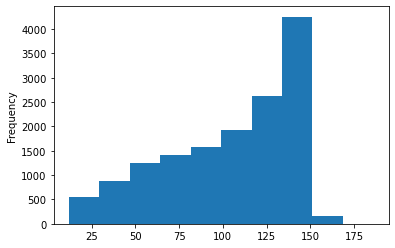

In [10]:
dataset['text'].str.len().plot.hist()

In [11]:
dataset['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

<AxesSubplot:>

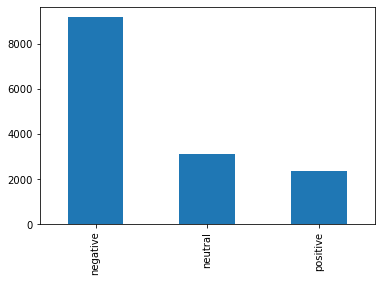

In [12]:
dataset['airline_sentiment'].value_counts().plot.bar()

#### Getting rid of symbols which are not useful, and converting the uppercase letters to lowercase

In [13]:
dataset['text'] = dataset['text'].apply(lambda x: x.lower())
dataset['text']

0        @united hence why i've been asking for the cus...
1               @americanair great customer service thanks
2        @jetblue captain "takes as lot of muscles to f...
3        @usairways dominick l. at la guardia airport n...
4        @americanair am on web site requesting refund ...
                               ...                        
14635    @united\nyou really know how to piss people of...
14636    @virginamerica that doesn't look to fat to me!...
14637    @usairways so when was i supposed to call the ...
14638    @united she's the type of person that can make...
14639    @jetblue just dmed. thanks so much for address...
Name: text, Length: 14640, dtype: object

#### Getting rid of the symbols with the help of Regular Expressions(Regex)

In [14]:
dataset['text'] = dataset['text'].apply(lambda text : re.sub('[^a-zA-Z0-9\s]',"",text))
dataset['text']

0        united hence why ive been asking for the custo...
1                americanair great customer service thanks
2        jetblue captain takes as lot of muscles to fro...
3        usairways dominick l at la guardia airport nyc...
4        americanair am on web site requesting refund f...
                               ...                        
14635    united\nyou really know how to piss people off...
14636    virginamerica that doesnt look to fat to me it...
14637    usairways so when was i supposed to call the i...
14638    united shes the type of person that can make a...
14639    jetblue just dmed thanks so much for addressin...
Name: text, Length: 14640, dtype: object

#### Converting the text to numbers so that the neural networks can deal with it --> Tokenizer will help with this

In [15]:
dataset['text'].values

array(['united hence why ive been asking for the customer service phone number so i can speak to a real person to get this sorted out',
       'americanair great customer service thanks',
       'jetblue captain takes as lot of muscles to frown but just a few to smile yall ready to go flyin i mean now i am',
       ...,
       'usairways so when was i supposed to call the internet desk especially since my reservation told me to directly call the main 1800 number',
       'united shes the type of person that can make a customers day i fly 100 times a year amp shes one of the top flight attendants ive had',
       'jetblue just dmed thanks so much for addressing this so quickly'],
      dtype=object)

In [16]:
tokenizer = Tokenizer(num_words=5000, split=" ")
tokenizer.fit_on_texts(dataset['text'].values)

#### Converting the words to numbers using the text-to-sequence method, and
#### Using pad_sequences to make the tweets of same length

In [17]:
X = tokenizer.texts_to_sequences(dataset['text'].values)
X = pad_sequences(X)

In [18]:
X[:6]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    5, 2054,   69,
         113,   45,  634,    7,    2,   50,   42,   97,  163,   44,    3,
          34,  355,    1,    4,  536,  322,    1,   30,   29, 2055,   52],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,   13,  114,   50,   42,   36],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          17, 1001,  822,   86,  526,   18,    1,   31,   41,    4,  520,
           1, 2455,  405,  714,    1,  128,    3,  563,   39,    3,   93],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,   12, 4598,   27,  658,  110,  501,
         795,    2, 1054,  204,   50,   42, 4599,  619,   15,  184,  729],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,   13,   

### All the arrays are of same length since they are now padded with zeroes

In [19]:
X.shape

(14640, 33)

In [20]:
model = Sequential()

model.add(Embedding(5000, 256, input_length = X.shape[1]))
model.add(Dropout(0.3))

model.add(LSTM(256, return_sequences=True, dropout = 0.3, recurrent_dropout = 0.2))

model.add(LSTM(256, dropout = 0.3, recurrent_dropout = 0.2))

model.add(Dense(3, activation = 'softmax'))

### Softmax function is used since it is a classification problem

In [21]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 33, 256)           1280000   
_________________________________________________________________
dropout (Dropout)            (None, 33, 256)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 33, 256)           525312    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense (Dense)                (None, 3)                 771       
Total params: 2,331,395
Trainable params: 2,331,395
Non-trainable params: 0
_________________________________________________________________


In [22]:
y = pd.get_dummies(dataset['airline_sentiment']).values

In [23]:
[print(dataset['airline_sentiment'][i], y[i]) for i in range(0,7)]

negative [1 0 0]
positive [0 0 1]
neutral [0 1 0]
positive [0 0 1]
neutral [0 1 0]
negative [1 0 0]
positive [0 0 1]


[None, None, None, None, None, None, None]

### The text is converted into numbers

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [25]:
model.fit(x=X_train, y=y_train, epochs=10, batch_size=32, verbose=2)

Epoch 1/10
366/366 - 153s - loss: 0.6485 - accuracy: 0.7353
Epoch 2/10
366/366 - 151s - loss: 0.4327 - accuracy: 0.8320
Epoch 3/10
366/366 - 149s - loss: 0.3448 - accuracy: 0.8724
Epoch 4/10
366/366 - 151s - loss: 0.2881 - accuracy: 0.8894
Epoch 5/10
366/366 - 151s - loss: 0.2376 - accuracy: 0.9127
Epoch 6/10
366/366 - 153s - loss: 0.2006 - accuracy: 0.9275
Epoch 7/10
366/366 - 157s - loss: 0.1680 - accuracy: 0.9387
Epoch 8/10
366/366 - 178s - loss: 0.1434 - accuracy: 0.9486
Epoch 9/10
366/366 - 166s - loss: 0.1308 - accuracy: 0.9524
Epoch 10/10
366/366 - 169s - loss: 0.1097 - accuracy: 0.9600


In [26]:
model.save(r'C:\Users\UMANG\Downloads\Py_DS_ML_Bootcamp-master\Refactored_Py_DS_ML_Bootcamp-master\22-Deep Learning\TensorFlow_FILES\TensorFlow_FILES\Notebooks\Sentiment_analysis.h5')

In [29]:
loss_acc = pd.DataFrame(model.history.history)
loss_acc.head()

,loss,accuracy
0,0.648457,0.735314
1,0.432735,0.831967
2,0.344765,0.872353
3,0.288072,0.889430
4,0.237629,0.912739


<AxesSubplot:>

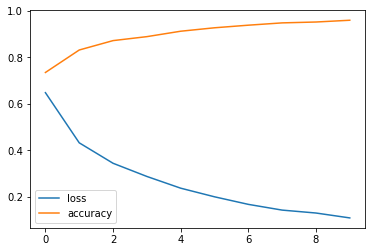

In [30]:
loss_acc.plot()

### Loss and accuracy is analysed

In [32]:
prediction = model.predict(X_test)

[print(dataset['text'][i], prediction[i], y_test[i]) for i in range(0,7)]

united hence why ive been asking for the customer service phone number so i can speak to a real person to get this sorted out [0.52325207 0.45409086 0.02265706] [1 0 0]
americanair great customer service thanks [9.9796849e-01 2.0107895e-03 2.0732301e-05] [1 0 0]
jetblue captain takes as lot of muscles to frown but just a few to smile yall ready to go flyin i mean now i am [9.9997854e-01 1.8465082e-05 3.0057556e-06] [1 0 0]
usairways dominick l at la guardia airport nyc gives the absolute best customer service thanku checking in made easy [9.9969280e-01 1.9346052e-04 1.1385166e-04] [1 0 0]
americanair am on web site requesting refund for cancelled flightled flight it requires numerical document number where get it [9.99860048e-01 1.05233376e-04 3.47211826e-05] [1 0 0]
usairways how many agents do you have working to handle the thousands of calls [0.01178728 0.02799356 0.96021914] [0 1 0]
usairways she also appreciated having her very own hashtag  lucycat [9.9998868e-01 1.0068013e-05 1.3

[None, None, None, None, None, None, None]